--------------------------------------------------START ORIGINAL VERSION:--------------------------------------------------
Processing iteration 0
Processing iteration 20
Processing iteration 40
Processing iteration 60
Processing iteration 80


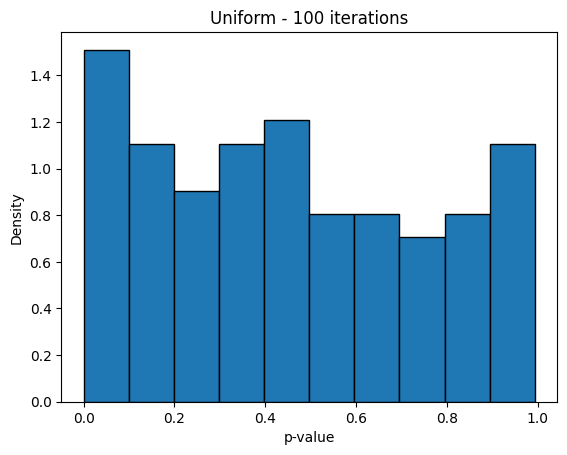

In [ ]:
import numpy as np
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

from CoRT_builder import CoRT
import utils
import parametric
import oc
from mpmath import mp

import importlib

importlib.reload(utils)
importlib.reload(parametric)

n_target = 30
n_source = 10
p = 10
K = 3
Ka = 1
h = 30
lamda = 0.1
s_vector = [0] * 2
T = 3
s = len(s_vector)
CoRT_model = CoRT(alpha=lamda)
p_values = []
alpha = 0.05
iteration = 100

print("-"*50 + "START ORIGINAL VERSION:" + "-"*50)

for step in range(iteration):
    if (step % 20 == 0):
        print(f"Processing iteration {step}")
        
    target_data, source_data = CoRT_model.gen_data(n_target, n_source, p, K, Ka, h, s_vector, s, "AR")
    similar_source_index = CoRT_model.find_similar_source(n_target, K, target_data, source_data, T=T, verbose=False)
    X_combined, y_combined = CoRT_model.prepare_CoRT_data(similar_source_index, source_data, target_data)

    model = Lasso(alpha=lamda, fit_intercept=False, tol=1e-10, max_iter=10000000)
    model.fit(X_combined, y_combined.ravel())
    beta_hat_target = model.coef_[-p:]

    active_indices = np.array([i for i, b in enumerate(beta_hat_target) if b != 0])
    initial_active_indices = active_indices

    if len(active_indices) == 0:
        print(f"Iteration {step}: Lasso selected no features. Skipping.")
        continue

    j = np.random.choice(len(active_indices))

    X_target = target_data["X"]
    y_target = target_data["y"]
    X_active, X_inactive = utils.get_active_X(beta_hat_target, X_target)

    etaj, etajTy = utils.construct_test_statistic(y_target, j, X_active)

    Sigma = np.eye(n_target)
    b_global = Sigma @ etaj @ np.linalg.pinv(etaj.T @ Sigma @ etaj)
    a_global = (Sigma - b_global @ etaj.T) @ y_target

    folds = utils.split_target(T, X_target, y_target, n_target)

    tn_sigma = mp.mpf((np.sqrt(etaj.T @ Sigma @ etaj)).item())
    z_k = -20 
    z_max = 20 

    Z_train_list = parametric.get_Z_train(z_k, folds, source_data, a_global, b_global, lamda, K, T)
    Z_val_list, similar_source, cnt_vote, is_similar = parametric.get_Z_val(z_k, folds, T, K, a_global, b_global, lamda, source_data)

    target_data_current = {"X": X_target, "y": a_global + z_k * b_global}
    X_combined_new, y_combined_new = CoRT_model.prepare_CoRT_data(similar_source, source_data, target_data_current)
    L_CoRT, R_CoRT, Az = parametric.get_Z_CoRT(X_combined_new, similar_source, lamda, a_global, b_global, source_data, z_k)

    offset = p * len(similar_source_index)
    Az_target_only = np.array([idx - offset for idx in Az if idx >= offset])

    z_k = -20
    z_list = [z_k] 
    Az_list = []   

    while z_k < z_max:
        L_train, R_train = oc.get_Z_train(z_k, folds, source_data, a_global, b_global, lamda, K, T)
        L_val, R_val = oc.get_Z_val(folds, T, K, a_global, b_global, z_k, lamda, source_data)

        target_data_current = {"X": X_target, "y": a_global + z_k * b_global}
        current_similar_source_index = utils.find_similar_source(z_k, a_global, b_global, lamda, n_target, K, target_data_current, source_data, T)
        X_combined_current, y_combined_current = CoRT_model.prepare_CoRT_data(current_similar_source_index, source_data, target_data_current)
        L_CoRT, R_CoRT, current_active_set_global = oc.get_Z_CoRT(X_combined_current, current_similar_source_index, lamda, a_global, b_global, source_data, z_k)

        L_final, R_final = oc.combine_Z(L_train, R_train, L_val, R_val, L_CoRT, R_CoRT)

        stopper = None
        if R_final == R_train: 
            stopper = "TRAIN"
        elif R_final == R_val: 
            stopper = "VAL"
        else: 
            stopper = "CORT"

        current_offset = p * len(current_similar_source_index)
        current_active_set_target = np.array([idx - current_offset for idx in current_active_set_global if idx >= current_offset])
        Az_list.append(current_active_set_target)

        z_k = max(R_final, z_k) + 1e-5

        if z_k >= z_max:
            z_list.append(z_max)
        else:
            z_list.append(z_k)

        if z_k >= z_max: 
            break

    z_interval = []
    for i in range(len(Az_list)):
        if np.array_equal(active_indices, Az_list[i]):
                z_interval.append([z_list[i], z_list[i+1] - 1e-10]) 

    # Merge intervals
    new_z_interval = []
    for interval in z_interval:
        if len(new_z_interval) == 0:
            new_z_interval.append(interval)
        else:
            dif = abs(interval[0] - new_z_interval[-1][1])
            if dif < 0.001:
                new_z_interval[-1][1] = interval[1]
            else:
                new_z_interval.append(interval)
    original_z_interval = new_z_interval
    is_z_obs_in_intervals = False
    for i, interval in enumerate(original_z_interval):
        if interval[0] <= etajTy <= interval[1]:
            is_z_obs_in_intervals = True
            break

    if is_z_obs_in_intervals == False:
        print(f" WARNING: z_obs is not in the intervals:\nz_obs: {etajTy}\nIntervals:{original_z_interval}")

    original_p_value = utils.pivot(active_indices, Az_list, z_list, etaj, etajTy, 0, Sigma)
    p_values.append(original_p_value)

plt.hist(p_values, bins=10, edgecolor='black', density=True)
plt.title(f"Uniform - {iteration} iterations")
plt.xlabel("p-value")
plt.ylabel("Density")
plt.show()